# Web Science Coursework

## Dependencies

In [ ]:
%%capture
!pip install tweepy
!pip install mongodb
!pip install pip install networkx

## 1) [Total 15 marks] Develop a crawler to access as much Twitter data as possible.

### a) [5 marks] Use Twitter streaming API for collecting 1% data.

In [1]:
import tweepy
import pymongo
from pymongo import MongoClient
import json 
from datetime import datetime
import pprint as pp
import re
import numpy as np
import pandas as pd
import networkx as nx


In [2]:
# Twitter Access Details
CONSUMER_KEY = 'sPTfr4cCAh09JrBijhDbdLUDd'
CONSUMER_SECRET ='1BKo0hEUdDTd8GLHDmqiwW8mNuTdgFCn93S5vMolTCCIdEb5VH'
ACCESS_TOKEN ='3910851693-uyVpoaDuACfypLQEuNyniAljLHNI9xcJxn24mvS'
ACCESS_TOKEN_SECRET ='YvkddqNpWtgdgb1DfoBlU8jejOC83oFsqWi1tOzx08b9W'

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET ) 
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

In [3]:
# Custom function used to store tweets inside the database
# The function expects the tweet in a json format
def insert_tweet_db(json_data):
    # Connect to the local Mongo DB
    client = MongoClient()

    # Use a custom database called twitterDB. If it does not exist
    # it will be created
    db = client.twitterDB

    # Format the date format in a format compatible with MongoDB
    format_created_at = datetime.strptime(json_data['created_at'], '%a %b %d %H:%M:%S +0000 %Y')
    json_data['created_at'] = format_created_at

    #print("Tweet collected at " + str(json_data['created_at']))

    # Insert data in MONGODB
    db["twitterCollection"].insert_one(json_data)
    

In [4]:
# Implement custom StreamListener
class StreamListener(tweepy.StreamListener):    
        
    def on_connect(self):
        print("Connected to the streaming API")
 
    def on_error(self, status_code):
        # Print an error message and the relative error code if an error occurs
        print('An error has occured. Status Code: ' + repr(status_code))
        return False
 
    def on_data(self, data):
        try:
            insert_tweet_db(json.loads(data))
            return
        except Exception as error:
            print(error)
            pass

In [5]:
# Create the api object reference
api=tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True,parser=tweepy.parsers.JSONParser())

### b. [10 marks] Enhance the crawling using the hybrid architecture of Twitter Streaming & REST APIs.

#### Use streaming API( filtering or sample API ) (this is ‘ a’ above)

In [ ]:
# Run the streaming API. Specify the collection we want to use 
# and start the stream. Filter tweets by considering only english tweets that are 
# UK based. 
streamListener = StreamListener()
customStream = tweepy.Stream(auth = api.auth, listener=streamListener)
customStream.filter(languages=['en'],locations=[-7.57216793459, 49.959999905, 1.68153079591, 58.6350001085], is_async=True)


#### Keyword based and/or user based REST probes

In [6]:
world_trends = api.trends_available()
# Find the United Kingdom WOEID
UK_woeid = ""
for world_trend in world_trends:
    if "name" in world_trend:
        if world_trend["name"] == "United Kingdom":
            UK_woeid = world_trend["woeid"]
            break
            
print("United Kingdom woeid: " + str(UK_woeid))

United Kingdom woeid: 23424975


In [7]:
# Get all the top trends in the united states
UK_trends_list = api.trends_place(id = UK_woeid)[0]['trends']
# Extract only the trends names. We are interested in the keywords. 
UK_trends = [UK_trend['name'] for UK_trend in UK_trends_list]
print(UK_trends)

['#FridayFeeling', '#GretaThunberg', '#boohoo', '#sbsevent2020', '#StupidLove', 'Un De Sceaux', 'sun yang', 'Jeremy Hunt', 'Hewlett Packard', 'Lady Gaga', 'Duncan Scott', 'Geneva Motor Show', 'Jane McDonald', 'Michael Santos', '#COVID2019', '#PurpleFriday', '#ShaggedMarriedAnnoyed', '#ON1stWin', '#GlobalScouseDay', '#ScottishArchivesDay', '#FlashbackFriday', '#bestcompaniesday', '#NewMusicFriday', '#ISAWITFIRST', '#payday', '#officecomplimentbeatles', '#NiceToMeetYaWorldTour', '#coronavirusnigeria', '#ScienceInSongsAndMovies', '#DriveToSurvive', '#F1Inbox', '#ONGlobalParty', '#LeapYear', '#WeStandWithTheRose', '#mlnsummit', '#WallisWeekend', '#UELdraw', '#ENGvPAK', '#NUEAwards', '#SuperMinLondon', '#uhurumustgo', '#deathly', '#CRCObserv', '#StDavidsDay', '#RareDiseaseDay', '#VisibleGovernance', '#wanteddownunder', '#CRCScotland', '#MEHEM2020', '#NJIRC20']


In [10]:
# Helper function used in order to get tweets by using the rest API 
def get_tweets_rest(key_words, api, n_items=3000, schedule=False):
    print(f"Collecting {n_items} tweets")
    # Chain the key_words for search 
    key_words_string = " OR ".join(key_words)

    cursor = tweepy.Cursor(api.search, q = key_words_string, lang = "en").items(n_items)
    while True:
        try:
            status = cursor.next()
            # Insert into db
            try:
                insert_tweet_db(status._json)
            except:
                # If an error occurs when trying to insert 
                # into the DB continue
                continue
        except tweepy.TweepError:
            time.sleep(60 * 15)
            continue
        except StopIteration:
            break
    print("Done collecting tweets")

In [11]:
# Create the api object reference
api=tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

# Pass the top 5 trends. Tried with 10 but apparently there is a limit in the number of tweets that can be passed
get_tweets_rest(UK_trends[:5], api, n_items=200)

Done collecting tweets


## 2) [25 marks] Grouping of tweets: Group the tweets based on content analysis, You can collect the data and then cluster them using any off-the shelf software; or use any locality sensitive hashing software; or build a content index and group them

In [9]:
# Get all data from the DB
client = MongoClient()
db = client.twitterDB
tweets = db.twitterCollection.find()

In [10]:
# Helper function used to clean tweets text
# Reference used https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/
def clean_tweet(tweet): 
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

In [11]:
# Clean tweet texts
tweets_list = []
for tweet in tweets:
    tweet['text'] = clean_tweet(tweet['text'])
    tweets_list.append(tweet)

In [12]:
# Helper function used to convert tweets into frames 
def convert_tweet_to_frame(tweets):
    dataFrame = pd.DataFrame()
    # Tweets info
    dataFrame['_id'] = np.array([tweet['_id'] for tweet in tweets])
    dataFrame['text'] = np.array([tweet['text'] for tweet in tweets])
    dataFrame['text_len'] = np.array([len(tweet['text']) for tweet in tweets])
    dataFrame['created_at'] = np.array([tweet["created_at"] for tweet in tweets])
    dataFrame['source'] = np.array([tweet["source"] for tweet in tweets])
    
    dataFrame['likes'] = np.array([tweet["favorite_count"] for tweet in tweets])
    dataFrame['retweets'] = np.array([tweet["retweet_count"] for tweet in tweets])
    dataFrame['hashtags'] = np.array([[el['text'] for el in tweet['entities']['hashtags']] for tweet in tweets])
    
    # Replies info 
    dataFrame['in_reply_to_screen_name'] = np.array(list(tweet['in_reply_to_screen_name'] for tweet in tweets))
    dataFrame['in_reply_to_status_id_str'] = np.array(list(tweet['in_reply_to_status_id_str'] for tweet in tweets))
    dataFrame['in_reply_to_user_id_str'] = np.array(list(tweet['in_reply_to_user_id_str'] for tweet in tweets))
    dataFrame['is_quote_status'] = np.array(list(tweet['is_quote_status'] for tweet in tweets))
    
    # Retweeted info
    dataFrame['retweeted_screen_name'] = np.array([tweet['retweeted_status']['user']['screen_name'] if "retweeted_status" in tweet else None for tweet in tweets])
    dataFrame['retweeted_id'] = np.array([tweet['retweeted_status']['user']['id_str'] if "retweeted_status" in tweet else None for tweet in tweets])
    dataFrame['retweeted'] = np.array([tweet['retweeted'] for tweet in tweets])
    
    # Getting user mentions information
    dataFrame['user_mentions_screen_name'] = np.array([[el['screen_name'] for el in tweet['entities']['user_mentions']] for tweet in tweets])
    dataFrame['user_mentions_id'] = np.array([[el['id_str'] for el in tweet['entities']['user_mentions']] for tweet in tweets])

    # Original Author info
    dataFrame['user_screen_name'] = np.array([tweet["user"]['screen_name'] for tweet in tweets])
    dataFrame['user_id_str'] = np.array([tweet["user"]['id_str'] for tweet in tweets])
    dataFrame['user_followers_no'] = np.array([tweet["user"]['followers_count'] for tweet in tweets])
    

    return dataFrame
    

In [13]:
twitter_df = convert_tweet_to_frame(tweets_list)
twitter_df.head(5)

,_id,text,text_len,created_at,source,likes,retweets,hashtags,in_reply_to_screen_name,in_reply_to_status_id_str,in_reply_to_user_id_str,is_quote_status,retweeted_screen_name,retweeted_id,retweeted,user_mentions_screen_name,user_mentions_id,user_screen_name,user_id_str,user_followers_no
0,5e578ffdd8806e219b8be818,mander,6,2020-02-27 09:46:31,"<a href=""http://twitter.com/download/iphone"" r...",0,0,[],vinayvaani,1232963663834697728,295517563,False,None,None,False,"[vinayvaani, barandbench, harsh_mander, ColinG...","[295517563, 67577895, 851678476994191360, 9282...",shariquenomani,18548802,752
1,5e578ffdd8806e219b8be81a,I reckon he s unimpressed at you abandoning hi...,67,2020-02-27 09:46:32,"<a href=""http://twitter.com/download/android"" ...",0,0,[],connorcalland,None,395908788,False,None,None,False,[connorcalland],[395908788],SarahLouise1127,1198644980820123649,90
2,5e578fffd8806e219b8be81c,All the Little Promoters who think they know w...,110,2020-02-27 09:46:33,"<a href=""http://twitter.com/download/android"" ...",0,0,[],None,None,None,True,None,None,False,[],[],CaoimhGaga,577461112,189
3,5e578fffd8806e219b8be81e,Seen it happen in loads of schools in my career,47,2020-02-27 09:46:34,"<a href=""http://twitter.com/download/iphone"" r...",0,0,[],brassoteach,1232723123927224325,883448078346465281,False,None,None,False,[brassoteach],[883448078346465281],stevedale,15557216,1536
4,5e578fffd8806e219b8be820,Survivors 1975 drama series they got tha Buxto...,73,2020-02-27 09:46:34,"<a href=""http://twitter.com/download/iphone"" r...",0,0,[],LBCNews,1232953226292580352,2329058035,False,None,None,False,"[LBCNews, LBC]","[2329058035, 20973388]",jaysoncarmicha1,2890616279,222


### Describe your method for grouping. What software you used and how the groups are formed. [5 marks]

Reference: https://heartbeat.fritz.ai/k-means-clustering-using-sklearn-and-python-4a054d67b187
Tweets have been grouped by converting each tweet text vector by using the TFIDF vectoriser and then K-mean clustering has been used in order to find clusters. The elbow method has been used to find the optimal number of clusters. Each cluster has then been analyised in order to identify the most important words

In [14]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd

/Users/speggiorinalessandro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [15]:
# Create the tfidfVectoriser and fit_transform it by using tweets text
tfidf_vect = TfidfVectorizer(stop_words="english") 
training_set = tfidf_vect.fit_transform(twitter_df["text"])

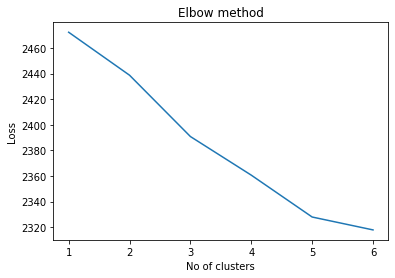

In [16]:
# use the elbow method to find best k value
loss =[]
for i in range(1, 7):
    kmeans = KMeans(n_clusters = i).fit(training_set)
    kmeans.fit(training_set)
    loss.append(kmeans.inertia_)

plt.plot(range(1, 7), loss)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Loss')
plt.show()

In [17]:
# The best value for K would be 5
# Compute kmeans
K_means = KMeans(n_clusters=5)
K_means.fit(training_set)

# Assign those cluster back to the dataset
twitter_df['cluster_label'] = K_means.labels_.tolist()

In [18]:
twitter_df.head(1)

,_id,text,text_len,created_at,source,likes,retweets,hashtags,in_reply_to_screen_name,in_reply_to_status_id_str,...,is_quote_status,retweeted_screen_name,retweeted_id,retweeted,user_mentions_screen_name,user_mentions_id,user_screen_name,user_id_str,user_followers_no,cluster_label
0,5e578ffdd8806e219b8be818,mander,6,2020-02-27 09:46:31,"<a href=""http://twitter.com/download/iphone"" r...",0,0,[],vinayvaani,1232963663834697728,...,False,None,None,False,"[vinayvaani, barandbench, harsh_mander, ColinG...","[295517563, 67577895, 851678476994191360, 9282...",shariquenomani,18548802,752,0


In [19]:
# Extract dataframes for each cluster
cluster0 = twitter_df[twitter_df['cluster_label'] == 0]
cluster1 = twitter_df[twitter_df['cluster_label'] == 1]
cluster2 = twitter_df[twitter_df['cluster_label'] == 2]
cluster3 = twitter_df[twitter_df['cluster_label'] == 3]
cluster4 = twitter_df[twitter_df['cluster_label'] == 4]

clusters_list = [cluster0, cluster1, cluster2, cluster3, cluster4]

### Extract important usernames; hashtags and entities/concepts from the group

In [20]:
# Extract Important hashtags
top_hashtags = {}
for i in range(len(clusters_list)):
    top_hashtags["cluster" + str(i)] = {}
    for hashtag_list in clusters_list[i]['hashtags']:
        for hashtag in hashtag_list:
            if hashtag in top_hashtags["cluster" + str(i)]:
                top_hashtags["cluster" + str(i)][hashtag] += 1
            else:
                top_hashtags["cluster" + str(i)][hashtag] = 1
            
# Print results
for el in top_hashtags:
    sorted_dict_items = list({k: v for k, v in sorted(top_hashtags[el].items(), key=lambda item: item[1], reverse=True)}.items())
    # Print top 3 values
    sorted_dict_items = sorted_dict_items[:3]
    print(el)
    print("=====")
    
    if len(sorted_dict_items) > 0:
        for el in sorted_dict_items:
            print(el[0] + ":" + str(el[1]))
    else:
        print("No hashtags")
    print("=====")
   
    

cluster0
=====
ONVIDEOPARTY:79
ThursdayThoughts:25
uksnow:13
=====
cluster1
=====
ONVIDEOPARTY:207
BringItON:124
ONMusicVideo:116
=====
cluster2
=====
snow:10
ONVIDEOPARTY:4
london:2
=====
cluster3
=====
HelloHanbinIsFree:160
iKON:14
HelloHanbinIsFREE:14
=====
cluster4
=====
Eurovision:65
ESC2020:27
=====


In [21]:
# Extract Important mentions
top_mentions = {}
for i in range(len(clusters_list)):
    top_mentions["cluster" + str(i)] = {}
    for mention_list in clusters_list[i]['user_mentions_screen_name']:
        for mention in mention_list:
            if mention in top_mentions["cluster" + str(i)]:
                top_mentions["cluster" + str(i)][mention] += 1
            else:
                top_mentions["cluster" + str(i)][mention] = 1
# Print results
for el in top_mentions:
    sorted_dict_items = list({k: v for k, v in sorted(top_mentions[el].items(), key=lambda item: item[1], reverse=True)}.items())
    # Print top 3 values
    sorted_dict_items = sorted_dict_items[:3]
    print(el)
    print("=====")
    
    if len(sorted_dict_items) > 0:
        for el in sorted_dict_items:
            print(el[0] + ":" + str(el[1]))
    else:
        print("No mentions")
    print("=====")
   
    

cluster0
=====
JamesNewmanUk:19
BTS_twt:19
Eurovision:11
=====
cluster1
=====
BTS_twt:56
btschartdata:38
soompi:19
=====
cluster2
=====
TeeKONed:4
little_ikonic:2
A_AMilne:2
=====
cluster3
=====
abhijitmajumder:34
ikonavy:20
ikonphile:14
=====
cluster4
=====
bbceurovision:87
JamesNewmanUk:87
Eurovision:27
=====


### Provide statistics on the data collected (part 1) and the resulting groups(grouped data) 

There are different statistics that can be taken into account for this task. Possible ones are
- Total number of elements per cluster
- Average tweets lenght
- Average likes
- Average retweets

In [22]:
# Add also the original dataset to the list of clusters
clusters_dict = {"cluster0": cluster0, 
                "cluster1": cluster1,
                "cluster2": cluster2,
                "cluster3": cluster3,
                "cluster4": cluster4,
                "Original Dataframe": twitter_df}

In [23]:
for key, value in clusters_dict.items():
    print(key  + " has " + str(value.shape[0])  + " elements")

cluster0 has 1756 elements
cluster1 has 235 elements
cluster2 has 137 elements
cluster3 has 288 elements
cluster4 has 93 elements
Original Dataframe has 2509 elements


In [24]:
for key, value in clusters_dict.items():
    print(key  + " has an average tweet length equal to " + str(value.mean()['text_len']))

cluster0 has an average tweet length equal to 71.71810933940775
cluster1 has an average tweet length equal to 69.60851063829787
cluster2 has an average tweet length equal to 71.36496350364963
cluster3 has an average tweet length equal to 89.33333333333333
cluster4 has an average tweet length equal to 75.74193548387096
Original Dataframe has an average tweet length equal to 73.67237943403747


In [25]:
for key, value in clusters_dict.items():
    print(key  + " has an average number of likes equal to " + str(value.mean()['likes']))

cluster0 has an average number of likes equal to 0.02050113895216401
cluster1 has an average number of likes equal to 0.0
cluster2 has an average number of likes equal to 0.014598540145985401
cluster3 has an average number of likes equal to 0.013888888888888888
cluster4 has an average number of likes equal to 0.0
Original Dataframe has an average number of likes equal to 0.016739736946990835


In [26]:
for key, value in clusters_dict.items():
    print(key  + " has an average number of retweets equal to " + str(value.mean()['retweets']))

cluster0 has an average number of retweets equal to 102.37927107061503
cluster1 has an average number of retweets equal to 1404.6127659574468
cluster2 has an average number of retweets equal to 46.64233576642336
cluster3 has an average number of retweets equal to 1115.7222222222222
cluster4 has an average number of retweets equal to 279.5483870967742
Original Dataframe has an average number of retweets equal to 344.192108409725


## [25 marks] Capturing & Organising User and hashtag information through a user interaction graph. First focus on user mentions and then on hashtags.

#### [15 marks] Develop a method to capture user information. Users occurring together in general data as well as on the groups (groups you formed in part 2 above) Differentiate between different kinds of networks like retweet network; quote tweets etc.

In [27]:
# Resource used https://github.com/ugis22/analysing_twitter/blob/master/Jupyter%20Notebook%20files/Interaction%20Network.ipynb
# Get the interactions between the different users
def get_interactions_set(row, reply=False, retweet=False, mention=False):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user_id_str"], row["user_screen_name"]
    # If there is no user then return None
    if user[0] is None:
        return (None, None), []
    
    # Create a set for all interactions. 
    interactions = set()
    
    # Check if tweets are reply, retweet or mentions
    if reply: 
        # Add the interaction for replies
        interactions.add((row["in_reply_to_user_id_str"], row["in_reply_to_screen_name"]))
    if retweet:
        # Add the interaction for retweets
        interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    if mention:
        # Add the interaction for mentions
        for mention_id, mention_screen_name in zip(row["user_mentions_id"], row["user_mentions_screen_name"]):
            interactions.add((mention_id,mention_screen_name ))
    
    # Discard if user id is in interactions
    interactions.discard((row["user_id_str"], row["user_screen_name"]))
    
    # Remove all empty interactions
    interactions.discard((None, None))
    return user, interactions

In [28]:
# Function used in order to get all user interactions. 
# The function returns a graph object and a dictionary representing all interactions
# between users
def get_users_interactions(df, graph, reply=False, retweet=False, mention=False):
    iteractions_dict = {}
    # For each row in our dataframe
    for index, tweet in df.iterrows():
        # get the interactions with that specific tweet
        user, interactions = get_interactions_set(tweet,reply, retweet, mention)
        # get the current user_id and screen_name
        user_id, user_name = user
        # For each of the possible interactions
        for interaction in interactions:
            iteractions_dict[user_name] = {}
            int_id, int_name = interaction
            # Add an edge from the user that posted the tweet to all other users that 
            # interacted somehow with the tweet
            graph.add_edges_from([(user_name,int_name)])

            # Keep a counter to see how users interacted
            if int_name in iteractions_dict[user_name]:
                iteractions_dict[user_name][int_name] += 1
            else:
                iteractions_dict[user_name][int_name] = 1
    return graph, iteractions_dict

In [29]:
# Create a dictionary of clusters to easy the analysis process
clusters_dict = {"cluster0": cluster0, 
                "cluster1": cluster1,
                "cluster2": cluster2,
                "cluster3": cluster3,
                "cluster4": cluster4,
                "Original Dataframe": twitter_df}


In [30]:
# Function used to generate a graph and plot it if necessary
# The function returns a dictionary mapping each cluster
# to its relative graph and the dictionary of all interactions
def analyse_network(clusters_dict, reply=False, retweet=False, mention=False, plot=False):
    results_dict = {}
    # For each cluster (including the general dataframe)
    for key, value in clusters_dict.items():
        print(key)
        results_dict[key] = {}
        graph = nx.DiGraph()
        graph, iteractions_dict = get_users_interactions(value, graph, reply=reply, retweet=retweet, mention=mention)
        results_dict[key]["graph"] = graph
        results_dict[key]["interactions_dict"] = iteractions_dict
        
        # Get the graph's degree to see if there are actually nodes
        degrees = [val for (node, val) in graph.degree()]
        # If the degree is 0 then just assign the graph to be empty
        if len(degrees) == 0:
            results_dict[key]["graph"] = None
        # Otherwise plot it if the flag has been defined
        if len(degrees) > 0 and plot: 
            # Plot the graph
            pos = nx.spring_layout(graph, k=0.05)
            try:
                plt.figure(figsize = (5,5))
                nx.draw(graph, pos=pos, node_color=range(graph.number_of_nodes()), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
                nx.draw_networkx_nodes(graph, pos=pos, node_size=300, node_color=colors_central_nodes)
                plt.savefig('graphfinal.png')
                plt.show()
            except:
                pass
            print("================")
        else:
            print("Graph has degree less equal to 0 or the flag plot=False")
            print("================")
    return results_dict

In [31]:
# With mentions
users_mentions = analyse_network(clusters_dict, reply=False, retweet=False, mention=True, plot=False)

cluster0
Graph has degree less equal to 0 or the flag plot=False
cluster1
Graph has degree less equal to 0 or the flag plot=False
cluster2
Graph has degree less equal to 0 or the flag plot=False
cluster3
Graph has degree less equal to 0 or the flag plot=False
cluster4
Graph has degree less equal to 0 or the flag plot=False
Original Dataframe
Graph has degree less equal to 0 or the flag plot=False


In [32]:
# Show the user dictionary as a reference for cluster 0 
pp.pprint(users_mentions['cluster0']['interactions_dict'])

{'1Davidhughes': {'KyleNSFW': 1},
 '1Mikeydfc': {'mickjmckay': 1},
 '2k20isameme': {'BTS_twt': 1},
 '6kTCIfej6bYjG8i': {'taylorswift13': 1},
 '7356peekay': {'tesssummers98': 1},
 '800dpiash': {'UGLegion': 1},
 'ABarlowFCCA': {'_NickyMarshall': 1},
 'ADMAgriculture': {'ragtseedsuk': 1},
 'AFBI_NI': {'ccoffey1': 1},
 'AdamGilson8': {'giffgaff': 1},
 'AfricaSosholite': {'AnneWaiguru': 1},
 'AidanRosewell': {'Tesco': 1},
 'Aimee_Aileen': {'boiiserendipity': 1},
 'Aisha10375967': {'taekook_ttwt': 1},
 'Aisling_Coyle': {'so27skincare': 1},
 'AlPinkerton': {'AmooreLouise': 1},
 'Alam981Alam': {'sheathcote972': 1},
 'Alan_Florance': {'texmandie': 1},
 'AllSportsMedia2': {'WWEUniverse': 1},
 'AnaglogsDaughtr': {'Fairyhouse': 1},
 'AndrewParrish7': {'lunchtimelady': 1},
 'Andrew_Clucas': {'Holbeach_UtdFC': 1},
 'AndrewarthaPat': {'ClaireSibbald': 1},
 'AndyMackguitar': {'Cherries_Wigan': 1},
 'AndyPickwell': {'petebrooksbank': 1},
 'AngelEmilyxxxx': {'Mikeangeloxxx': 1},
 'AngelHeart5609': {'jon

 'emma1995_louise': {'virginmedia': 1},
 'emmaaitkenF1': {'littleboydwight': 1},
 'emmavolney': {'simonjamesjupp': 1},
 'eurotrashsash': {'OttLepland': 1},
 'evac100': {'AureliaOT7': 1},
 'fatenazierah': {'ivejuneesya': 1},
 'fatimahilm': {'m3_qy': 1},
 'franyoons': {'bangtanism89_': 1},
 'gNadelyn_': {'vminggukx': 1},
 'gabriellelmngsd': {'only_iKON7': 1},
 'galileohhhh': {'Mhai_S21': 1},
 'garken27': {'cassiekeeling83': 1},
 'gazza081': {'AutoPickUK': 1},
 'geraintroberts0': {'offshootgallery': 1},
 'getawayygreen_x': {'iamamerrickan': 1},
 'girlforegone': {'solarisfire': 1},
 'gkse16': {'LBC': 1},
 'gothamcity56': {'alanjstedman': 1},
 'gurnblenston': {'fryuppolice': 1},
 'haebricara': {'JamesNewmanUk': 1},
 'hanbinnietrash': {'iKONIClikkiee': 1},
 'harriet_minns': {'merelapsed': 1},
 'hasmohsin': {'guardian': 1},
 'hayleyearl': {'jpembroke': 1},
 'hazeldine_ben': {'ChelmsfordCRC': 1},
 'heartseokjin04': {'btsworldwider': 1},
 'hemsby350': {'romfordlabour': 1},
 'heywoodbill': {'JGF

In [33]:
# Only retweets
users_retweets = analyse_network(clusters_dict, reply=False, retweet=True, mention=False, plot=False)

cluster0
Graph has degree less equal to 0 or the flag plot=False
cluster1
Graph has degree less equal to 0 or the flag plot=False
cluster2
Graph has degree less equal to 0 or the flag plot=False
cluster3
Graph has degree less equal to 0 or the flag plot=False
cluster4
Graph has degree less equal to 0 or the flag plot=False
Original Dataframe
Graph has degree less equal to 0 or the flag plot=False


In [34]:
# Only replies 
users_replies = analyse_network(clusters_dict, reply=True, retweet=False, mention=False, plot=False)

cluster0
Graph has degree less equal to 0 or the flag plot=False
cluster1
Graph has degree less equal to 0 or the flag plot=False
cluster2
Graph has degree less equal to 0 or the flag plot=False
cluster3
Graph has degree less equal to 0 or the flag plot=False
cluster4
Graph has degree less equal to 0 or the flag plot=False
Original Dataframe
Graph has degree less equal to 0 or the flag plot=False


#### [10 marks] Develop a mechanism to capture hashtag information occurring together in general data as well as on the groups. Objective is to build a user interaction graph through hashtag co-occurring information. (frequency doesn’t make such in this case)

In [35]:
# Resource used https://github.com/ugis22/analysing_twitter/blob/master/Jupyter%20Notebook%20files/Interaction%20Network.ipynb
# Get the interactions between the different hashtags
# The function returns a dictionary mapping hashtact relations
def get_hashtags_iter(df):
    hastags_dict = {}
    # For each row in the dataframe
    for index, row in df.iterrows():
        # Get each hashtags
        for hashtag in row['hashtags']:
            # If there are hashtags save their interaction as a set
            if hashtag not in hastags_dict:
                hastags_dict[hashtag] = set(row['hashtags'])
            else:
                hastags_dict[hashtag] = hastags_dict[hashtag].union(row['hashtags'])
            # Remove itself from the set
            hastags_dict[hashtag].remove(hashtag)
    
    # Remove every hashtag with no interaction
    final_dict = {}
    for key, value in hastags_dict.items():
        if len(value) != 0:
            final_dict[key] = value
    
    return final_dict 

cluster0 has 322 hashtags
cluster1 has 34 hashtags
cluster2 has 35 hashtags
cluster3 has 9 hashtags
cluster4 has 0 hashtags
Network Not defined
Original Dataframe has 386 hashtags


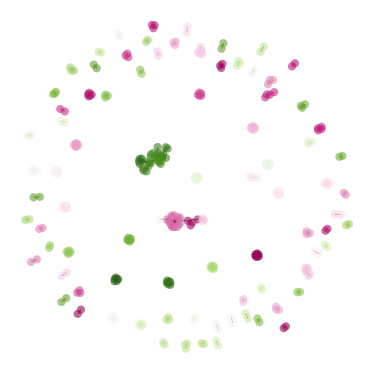

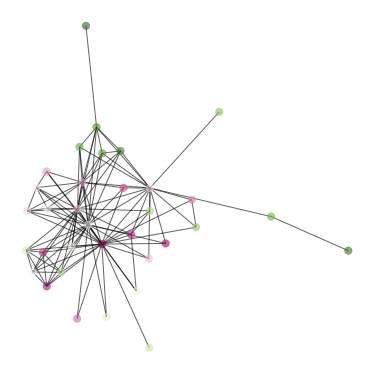

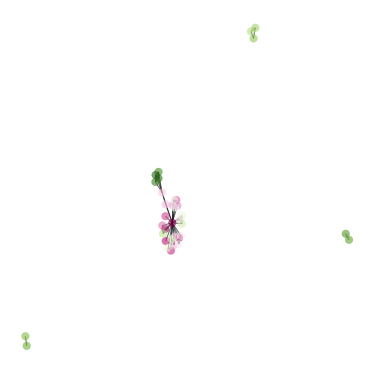

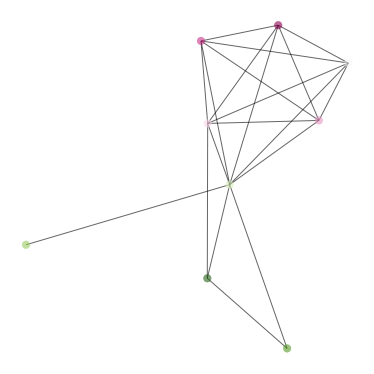

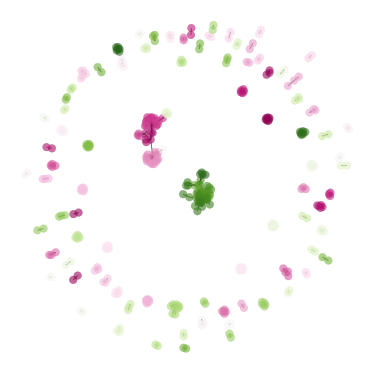

In [58]:
hashtags_dict = {}
# Plot a graph for each cluster considering hashtags
for key, value in clusters_dict.items():
    hashtags_dict[key] = {}
    # Map the interaction to the dictionary
    hashtags_dict[key]['interactions_dict'] = get_hashtags_iter(value)
    print(key + " has " + str(len(hashtags_dict[key]['interactions_dict'])) + " hashtags")
    graph = nx.Graph()
    
    # Add edges based on hashtags interactions
    for from_node, to_node in hashtags_dict[key]['interactions_dict'].items():
        for el in to_node: 
            graph.add_edge(from_node, el)
    
    # Save the graph for this specific hashtags interaction in the dictionary. None if the graph is empty
    degrees = [val for (node, val) in graph.degree()]
    hashtags_dict[key]['graph'] = graph if len(degrees) > 0 else None
    
    if len(degrees) >0: 
            pos = nx.spring_layout(graph, k=0.05)
            try:
                plt.figure(figsize = (5,5))
                nx.draw(graph, pos=pos, node_color=range(graph.number_of_nodes()), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
                nx.draw_networkx_nodes(graph, pos=pos, node_size=300, node_color=colors_central_nodes)
                plt.savefig('graphfinal.png')
                plt.show()
            except:
                pass
            print("================")
    else:
        print("Network Not defined")
    
    
            
    

In [37]:
# print the hashtag datastructure for cluster0
pp.pprint(hashtags_dict['cluster0']['interactions_dict'])

{'100yearsofcouncilhousing': {'councilhousing', 'cih'},
 '1918pandemic': {'stackingthecoffins'},
 '30off': {'save', 'waxing'},
 'ADFUTURES20': {'Facebook'},
 'AI': {'procurement'},
 'ARMY': {'BTS', 'ONVIDEOPARTY', 'BTSARMY'},
 'Abhinandan': {'HappySurpriseDayIndia', 'Pakistan', 'WorldsBiggestTeaParty'},
 'Airbnb': {'leaseholders', 'propertylaw'},
 'Arcade': {'MAME', 'PlayStation2'},
 'BJP': {'BJPBurningIndia', 'Gujarat2002', 'ShameonYou', 'DelhiRiots2020'},
 'BJPBurningIndia': {'Gujarat2002', 'ShameonYou', 'DelhiRiots2020', 'BJP'},
 'BTNTV': {'EventTV', 'StreamTeam'},
 'BTS': {'ARMY',
         'BTSARMY',
         'BringItOnProject',
         'MAP_OF_THE_SOUL_7',
         'ON',
         'ONVIDEOPARTY',
         '방탄소년단'},
 'BTS2020': {'InnovationFaceoff'},
 'BTSARMY': {'ARMY',
             'BTS',
             'BringItON',
             'ON',
             'ONMusicVideo',
             'ONVIDEOPARTY',
             '방탄소년단'},
 'BTSCOMEBACKSPECIAL': {'ONVIDEOPARTY'},
 'BTSComebackSpecial': {'ON

## 4) Network Analysis
### a. Analyse the data to generate network-based measures like ties, triads.

In [52]:
# Function used to analyse directed graphs
def analyse_graph(graph, triads=False):
    if graph is not None:
        print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

        degrees = np.array([val for (node, val) in graph.degree()])
        node_values = np.array([node for (node, val) in graph.degree()])
        vip = node_values[np.argmax(degrees)]
        # Get top nodes
        sorted_nodes = node_values[np.argsort(degrees)][::-1]

        print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}") 
        print(f"The maximum degree of the Graph is {np.max(degrees)}") 
        print(f"The node with maximum degree is {sorted_nodes[0]}")
        print(f"The top 5 nodes are {sorted_nodes[:5]}")

        # Compute and print triads
        if triads:
            print("Triads")
            print(nx.algorithms.triads.triadic_census(graph))
    else:
        print("Empty")
    print("=======")

In [53]:
# Analyse user mentions
for key, value in users_mentions.items():
    print(key)
    analyse_graph(value['graph'], True)

cluster0
There are 2357 nodes and 1627 edges present in the Graph
The average degree of the nodes in the Graph is 1.4
The maximum degree of the Graph is 19
The node with maximum degree is BTS_twt
The top 5 nodes are ['BTS_twt' 'JamesNewmanUk' 'lee_lizard' 'philwhelpdale' 'WendellThomas14']
Triads
{'003': 2175768639, '012': 3808392, '102': 9400, '021D': 1587, '021U': 553, '021C': 12, '111D': 0, '111U': 12, '030T': 7, '030C': 0, '201': 0, '120D': 0, '120U': 8, '120C': 0, '210': 0, '300': 0}
cluster1
There are 300 nodes and 267 edges present in the Graph
The average degree of the nodes in the Graph is 1.8
The maximum degree of the Graph is 56
The node with maximum degree is BTS_twt
The top 5 nodes are ['BTS_twt' 'btschartdata' 'soompi' 'KIMVpics' 'BTSChartDaily']
Triads
{'003': 4378203, '012': 74228, '102': 0, '021D': 53, '021U': 2616, '021C': 0, '111D': 0, '111U': 0, '030T': 0, '030C': 0, '201': 0, '120D': 0, '120U': 0, '120C': 0, '210': 0, '300': 0}
cluster2
There are 139 nodes and 78 e

In [54]:
# Analise network with retweets
for key, value in users_retweets.items():
    print(key)
    analyse_graph(value['graph'], True)

cluster0
There are 375 nodes and 226 edges present in the Graph
The average degree of the nodes in the Graph is 1.2
The maximum degree of the Graph is 10
The node with maximum degree is taebokkiii
The top 5 nodes are ['taebokkiii' 'BMG' 'sorafirstlove' 'Awake_Aileen' 'btsworldwider']
Triads
{'003': 8634730, '012': 83992, '102': 0, '021D': 3, '021U': 148, '021C': 2, '111D': 0, '111U': 0, '030T': 0, '030C': 0, '201': 0, '120D': 0, '120U': 0, '120C': 0, '210': 0, '300': 0}
cluster1
There are 290 nodes and 209 edges present in the Graph
The average degree of the nodes in the Graph is 1.4
The maximum degree of the Graph is 37
The node with maximum degree is btschartdata
The top 5 nodes are ['btschartdata' 'soompi' 'KIMVpics' 'BTSChartDaily' 'blvcksnow_twt']
Triads
{'003': 3963729, '012': 58110, '102': 0, '021D': 2, '021U': 1039, '021C': 0, '111D': 0, '111U': 0, '030T': 0, '030C': 0, '201': 0, '120D': 0, '120U': 0, '120C': 0, '210': 0, '300': 0}
cluster2
There are 20 nodes and 11 edges prese

In [55]:
# Analise network with replies
for key, value in users_replies.items():
    print(key)
    analyse_graph(value['graph'], True)

cluster0
There are 1162 nodes and 636 edges present in the Graph
The average degree of the nodes in the Graph is 1.1
The maximum degree of the Graph is 7
The node with maximum degree is lee_lizard
The top 5 nodes are ['lee_lizard' 'jahglennie' 'Chris_CPH' 'missnaolo1' 'Hoiskiez']
Triads
{'003': 260089544, '012': 728199, '102': 4633, '021D': 121, '021U': 13, '021C': 3, '111D': 0, '111U': 7, '030T': 0, '030C': 0, '201': 0, '120D': 0, '120U': 0, '120C': 0, '210': 0, '300': 0}
cluster1
There are 5 nodes and 3 edges present in the Graph
The average degree of the nodes in the Graph is 1.2
The maximum degree of the Graph is 2
The node with maximum degree is BTS_twt
The top 5 nodes are ['BTS_twt' 'btsvantete' 'winksobrien' 'BigHitEnt' 'btschewy']
Triads
{'003': 2, '012': 7, '102': 0, '021D': 0, '021U': 1, '021C': 0, '111D': 0, '111U': 0, '030T': 0, '030C': 0, '201': 0, '120D': 0, '120U': 0, '120C': 0, '210': 0, '300': 0}
cluster2
There are 91 nodes and 46 edges present in the Graph
The average

In [57]:
# Analise network with mentions
for key, value in hashtags_dict.items():
    print(key)
    analyse_graph(value['graph'], False)

cluster0
There are 322 nodes and 505 edges present in the Graph
The average degree of the nodes in the Graph is 3.1
The maximum degree of the Graph is 18
The node with maximum degree is ONVIDEOPARTY
The top 5 nodes are ['ONVIDEOPARTY' 'ThursdayThoughts' 'WWESSD' 'merthyr' 'kozel']
cluster1
There are 34 nodes and 113 edges present in the Graph
The average degree of the nodes in the Graph is 6.6
The maximum degree of the Graph is 25
The node with maximum degree is ONVIDEOPARTY
The top 5 nodes are ['ONVIDEOPARTY' 'ONMusicVideo' '방탄소년단' 'BringItON' 'BTS']
cluster2
There are 35 nodes and 62 edges present in the Graph
The average degree of the nodes in the Graph is 3.5
The maximum degree of the Graph is 23
The node with maximum degree is snow
The top 5 nodes are ['snow' 'london' 'outdoors' 'Puddingstone' 'campfire']
cluster3
There are 9 nodes and 20 edges present in the Graph
The average degree of the nodes in the Graph is 4.4
The maximum degree of the Graph is 8
The node with maximum degree